<a href="https://colab.research.google.com/github/edponce/DoyleInvestigators2/blob/main/project2_doyle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
# Import modules
import requests
import re, spacy
from collections import defaultdict
import pandas as pd
import numpy as np
import itertools
import pickle
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.ticker import MultipleLocator
%matplotlib inline
import random
from itertools import chain

In [32]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

import multiprocessing
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
nlp = spacy.load('en', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

import pickle

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

from random import shuffle

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [33]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load word2vec models

In [34]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import pickle

In [36]:
doyle_w2v_sent_300 = pickle.load(open('/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/models/doyle_w2v_model_dim300_window12_cb.sav', 'rb'))
doyle_w2v_sent_50 = pickle.load(open('/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/models/doyle_w2v_model_dim50_window12_cb.sav', 'rb'))

# Load data from each author

In [37]:
df_train = pd.read_csv('/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/data/data_documents/Rinehart_350_train.csv')
df_chri_350_train = pd.read_csv('/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/data/data_documents/Christie_350_train.csv').sample(n=int(len(df_train)/2.0), replace=False, random_state=1)
df_doyl_350_train = pd.read_csv('/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/data/data_documents/Doyle_350_train.csv').sample(n=int(len(df_train)/2.0), replace=False, random_state=1)

df_test = pd.read_csv('/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/data/data_documents/Rinehart_350_test.csv')
df_chri_350_test = pd.read_csv('/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/data/data_documents/Christie_350_test.csv')
df_doyl_350_test = pd.read_csv('/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/data/data_documents/Doyle_350_test.csv')

In [38]:
df_train1 = pd.read_csv('/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/data/data_documents/Rinehart_1400_train.csv')
df_chri_1400_train = pd.read_csv('/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/data/data_documents/Christie_1400_train.csv').sample(n=int(len(df_train1)/2.0), replace=False, random_state=1)
df_doyl_1400_train = pd.read_csv('/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/data/data_documents/Doyle_1400_train.csv').sample(n=int(len(df_train1)/2.0), replace=False, random_state=1)

df_test1 = pd.read_csv('/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/data/data_documents/Rinehart_1400_test.csv')
df_chri_1400_test = pd.read_csv('/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/data/data_documents/Christie_1400_test.csv')
df_doyl_1400_test = pd.read_csv('/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/data/data_documents/Doyle_1400_test.csv')

In [39]:
df_train2 = pd.read_csv('/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/data/data_documents/Rinehart_3500_train.csv')
df_chri_3500_train = pd.read_csv('/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/data/data_documents/Christie_3500_train.csv').sample(n=int(len(df_train2)/2.0), replace=False, random_state=1)
df_doyl_3500_train = pd.read_csv('/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/data/data_documents/Doyle_3500_train.csv').sample(n=int(len(df_train2)/2.0), replace=False, random_state=1)

df_test2 = pd.read_csv('/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/data/data_documents/Rinehart_3500_test.csv')
df_chri_3500_test = pd.read_csv('/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/data/data_documents/Christie_3500_test.csv')
df_doyl_3500_test = pd.read_csv('/content/drive/Shared drives/ECE-692 Rinehart Investigators /Project 2/data/data_documents/Doyle_3500_test.csv')

# Training MLP models

In [40]:
def w2v(df, model, dim):
  data_ls = []
  for i in range(len(df)):
    t = df.loc[i].values.tolist()
    data = []
    for x in t:
      if x in list(model.wv.vocab.keys()):
        kn = model[x].tolist()
        data.append(kn)
      else:
        unk = [0]*dim
        data.append(unk)
    data_ls.append(list(map(lambda x: sum(x)/len(x), zip(*data))))
  return data_ls

In [41]:
def training(df_train, df1, df2, model, dim):
  df_train = df_train.append(df1, ignore_index=True)
  df_train = df_train.append(df2, ignore_index=True)  
  print(df_train.shape)

  train_data = w2v(df_train, model, dim)
  print(len(train_data))
  df_tr = pd.DataFrame(train_data)
  df_tr['author'] = df_train['Label'].values.tolist()

  df_tr = df_tr.sample(frac=1).reset_index(drop=True)

  y_train = df_tr['author']
  x_train = df_tr.drop(['author'], axis=1)

  for i, x in enumerate(y_train.tolist()):
    if (x == 'christie' or x == 'rinehart'): 
      y_train[i] = 'other'

  print(np.unique(y_train))
  clf = MLPClassifier(hidden_layer_sizes=(50,50,50), max_iter=2000, alpha=0.0001,
                    validation_fraction=0.1,
                     solver='sgd', verbose=10,  random_state=2,tol=0.000000001)
  clf.fit(x_train, y_train)

  return clf

In [42]:
# Path to save MLP models
path = '/content/drive/My Drive/clf_doyle/'

## Train models with 50 dim embedding

In [25]:
clf_350_50 = training(df_train, df_chri_350_train, df_doyl_350_train, doyle_w2v_sent_50, 50)
filename = 'clf_350_50.sav'
pickle.dump(clf_350_50, open(path+filename, 'wb'))

In [ ]:
clf_1400_50 = training(df_train1, df_chri_1400_train,df_doyl_1400_train, doyle_w2v_sent_50, 50)
filename = 'clf_1400_50.sav'
pickle.dump(clf_1400_50, open(path+filename, 'wb'))

In [ ]:
clf_3500_50 = training(df_train2, df_chri_3500_train,df_doyl_3500_train, doyle_w2v_sent_50, 50)
filename = 'clf_3500_50.sav'
pickle.dump(clf_3500_50, open(path+filename, 'wb'))

## Train models with 300 dim embedding

In [43]:
clf_350_300 = training(df_train, df_chri_350_train, df_doyl_350_train, doyle_w2v_sent_300, 300)
filename = 'clf_350_300.sav'
pickle.dump(clf_350_300, open(path+filename, 'wb'))

(1420, 351)
1420
['doyle' 'other']
Iteration 1, loss = 0.67335007
Iteration 2, loss = 0.65670985
Iteration 3, loss = 0.63636474
Iteration 4, loss = 0.61735625
Iteration 5, loss = 0.60148763
Iteration 6, loss = 0.58999394
Iteration 7, loss = 0.58069305
Iteration 8, loss = 0.57368165
Iteration 9, loss = 0.56872145
Iteration 10, loss = 0.56493585
Iteration 11, loss = 0.56250772
Iteration 12, loss = 0.56064432
Iteration 13, loss = 0.55953311
Iteration 14, loss = 0.55860125
Iteration 15, loss = 0.55786884
Iteration 16, loss = 0.55733500
Iteration 17, loss = 0.55693769
Iteration 18, loss = 0.55670116
Iteration 19, loss = 0.55650254
Iteration 20, loss = 0.55627322
Iteration 21, loss = 0.55615017
Iteration 22, loss = 0.55600074
Iteration 23, loss = 0.55581628
Iteration 24, loss = 0.55554446
Iteration 25, loss = 0.55536133
Iteration 26, loss = 0.55515023
Iteration 27, loss = 0.55500068
Iteration 28, loss = 0.55487773
Iteration 29, loss = 0.55468143
Iteration 30, loss = 0.55464300
Iteration 31, 

In [ ]:
clf_1400_300 = training(df_train1, df_chri_1400_train,df_doyl_1400_train, doyle_w2v_sent_300, 300)
filename = 'clf_1400_300.sav'
pickle.dump(clf_1400_300, open(path+filename, 'wb'))

In [ ]:
clf_3500_300 = training(df_train2, df_chri_3500_train,df_doyl_3500_train, doyle_w2v_sent_300, 300)
filename = 'clf_3500_300.sav'
pickle.dump(clf_3500_300, open(path+filename, 'wb'))

# Testing MLP models

In [44]:
import warnings
warnings.filterwarnings("ignore")

In [45]:
def plot_confusion_matrix(cm,
                          target_names,
                          title,
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [46]:
def testing(df_test, df1, df2, model, clf, dim):
  df_test = df_test.append(df1, ignore_index=True)
  df_test = df_test.append(df2, ignore_index=True)  
  test_data = w2v(df_test, model,dim)

  df_te = pd.DataFrame(test_data)
  df_te['author'] = df_test['Label'].values.tolist()

  df_te = df_te.sample(frac=1).reset_index(drop=True)

  y_test = df_te['author']
  x_test = df_te.drop(['author'], axis=1)

  for i, x in enumerate(y_test.tolist()):
    if (x == 'christie' or x == 'rinehart'): 
      y_test[i] = 'other'

  y_pred = clf.predict(x_test)
  print('Test Accuracy: ', accuracy_score(y_test, y_pred))
  cm = confusion_matrix(y_test, y_pred)
  print('F1 Score: ', f1_score(y_test, y_pred, average='micro'))
  plot_confusion_matrix(cm,
                      normalize    = False,
                      target_names = ['Others', 'Doyle'],
                      title        = "Confusion Matrix")

  return y_test, y_pred

In [48]:
# Path from where to load MLP models
path = '/content/drive/My Drive/clf_doyle/'

## Testing with 50 dim embedding

Test Accuracy:  0.8381742738589212
F1 Score:  0.8381742738589212


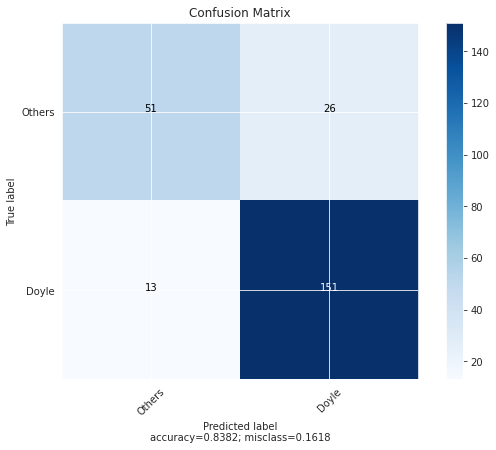

In [49]:
#filename = 'clf_350_50.sav'
#clf_350_50 = pickle.load(open(path+filename, 'rb'))
y_test_350_50, y_pred_350_50 = testing(df_test, df_chri_350_test, df_doyl_350_test, doyle_w2v_sent_50, clf_350_50, 50)

In [ ]:
#filename = 'clf_1400_50.sav'
#clf_1400_50 = pickle.load(open(path+filename, 'rb'))
y_test_1400_50, y_pred_1400_50 = testing(df_test1, df_chri_1400_test, df_doyl_1400_test, doyle_w2v_sent_50, clf_1400_50, 50)

In [ ]:
#filename = 'clf_3500_50.sav'
#clf_3500_50 = pickle.load(open(path+filename, 'rb'))
y_test_3500_50, y_pred_3500_50 = testing(df_test2, df_chri_3500_test, df_doyl_3500_test, doyle_w2v_sent_50, clf_3500_50, 50)

## Testing with 300 dim embedding

Test Accuracy:  0.8340248962655602
F1 Score:  0.8340248962655602


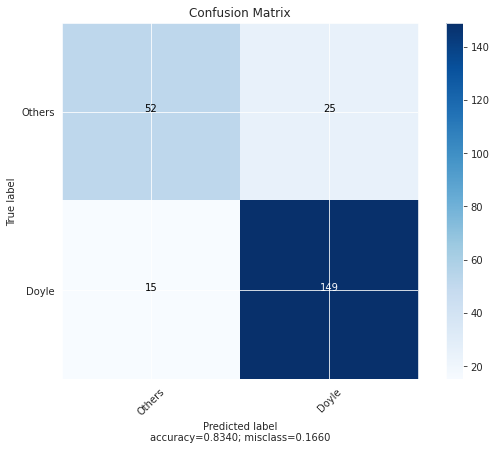

In [50]:
#filename = 'clf_350_300.sav'
#clf_350_300 = pickle.load(open(path+filename, 'rb'))
y_test_350_300, y_pred_350_300 = testing(df_test, df_chri_350_test, df_doyl_350_test, doyle_w2v_sent_300, clf_350_300, 300)

In [ ]:
#filename = 'clf_1400_300.sav'
#clf_1400_300 = pickle.load(open(path+filename, 'rb'))
y_test_1400_300, y_pred_1400_300 = testing(df_test1, df_chri_1400_test, df_doyl_1400_test, doyle_w2v_sent_300, clf_1400_300, 300)

In [ ]:
#filename = 'clf_3500_300.sav'
#clf_3500_300 = pickle.load(open(path+filename, 'rb'))
y_test_3500_300, y_pred_3500_300 = testing(df_test2, df_chri_3500_test, df_doyl_3500_test, doyle_w2v_sent_300, clf_3500_300, 300)

# Data Perturbation 

In [47]:
def pert_testing(df_test, model, clf, dim):
  test_data = w2v(df_test, model,dim)

  df_te = pd.DataFrame(test_data)
  df_te['author'] = df_test['Label'].values.tolist()

  df_te = df_te.sample(frac=1).reset_index(drop=True)

  y_test = df_te['author']
  x_test = df_te.drop(['author'], axis=1)

  for i, x in enumerate(y_test.tolist()):
    if (x == 'christie' or x == 'rinehart'): 
      y_test[i] = 'other'

  y_pred = clf.predict(x_test)
  print('Test Accuracy: ', accuracy_score(y_test, y_pred))
  cm = confusion_matrix(y_test, y_pred)
  print('F1 Score: ', f1_score(y_test, y_pred, average='micro'))
  plot_confusion_matrix(cm,
                      normalize    = False,
                      target_names = ['Others', 'Doyle'],
                      title        = "Confusion Matrix")

  return y_test, y_pred

In [54]:
import json
def load_corpus(fn: str) -> list:
    with open(fn) as fd:
        return json.load(fd)


def json_df (test_file):
  # Load documents from JSON file
  docs = load_corpus(test_file)
  num_docs = len(docs)
  print('Loaded', num_docs, 'documents for testing')

  # Process documents
  # Each document is represented as a dictionary with a 'label' and 'text' field
  text = []
  label = []
  for i, doc in enumerate(docs):
    text.append(re.split('#| |\--|\n', doc['text'])) 
    #text.append(re.split('#|\--|\n', doc['text']))
    label.append(doc['label'])

  #df = pd.DataFrame(text, columns = ['word_'+str(i) for i in range(len(text[0]))])
  df = pd.DataFrame(text)
  df['Label'] = label
  #print(df)
  return(df)      

## Load JSON files to df

In [60]:
#Add the perturbed data paths here
#Read perturbed data
paths_perturbed_data = [
  '/content/drive/My Drive/perturbed_data_doyle/perturbed_numericals_doyle_350.json', 
  '/content/drive/My Drive/perturbed_data_doyle/perturbed_numericals_doyle_1400.json',
  '/content/drive/My Drive/perturbed_data_doyle/perturbed_numericals_doyle_3500.json',
  '/content/drive/My Drive/perturbed_data_doyle/perturbed_synonym_doyle_350.json',
  '/content/drive/My Drive/perturbed_data_doyle/perturbed_synonym_doyle_1400.json',
  '/content/drive/My Drive/perturbed_data_doyle/perturbed_synonym_doyle_3500.json',
  #'/content/drive/My Drive/perturbed_data_doyle/perturbed_synonym_rinehart_350.json',
  #'/content/drive/My Drive/perturbed_data_doyle/perturbed_synonym_rinehart_1400.json',
  #'/content/drive/My Drive/perturbed_data_doyle/perturbed_synonym_rinehart_3500.json',
]
               
df_pert_350_num = json_df(paths_perturbed_data[0])
df_pert_1400_num = json_df(paths_perturbed_data[1]) 
df_pert_3500_num = json_df(paths_perturbed_data[2])

df_pert_350_syn = json_df(paths_perturbed_data[3])
df_pert_1400_syn = json_df(paths_perturbed_data[4]) 
df_pert_3500_syn = json_df(paths_perturbed_data[5])

Loaded 81 documents for testing
81
81
352
351
Loaded 15 documents for testing
15
15
1402
3526
Loaded 7 documents for testing
7
7
3530
3525
Loaded 81 documents for testing
81
81
352
352
Loaded 15 documents for testing
15
15
1404
3530
Loaded 7 documents for testing
7
7
3544
3530


## Testing with 50 dim embedding - Synonyms

Test Accuracy:  0.9259259259259259
F1 Score:  0.9259259259259259


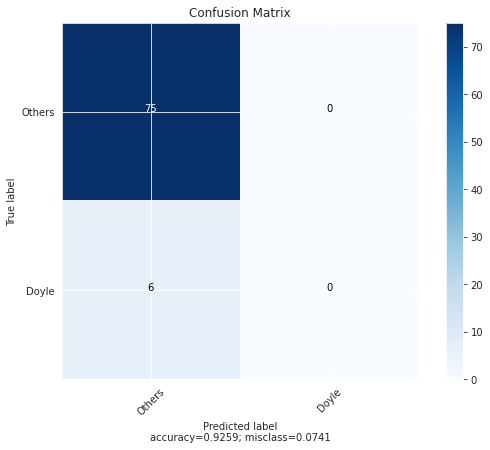

In [61]:
#filename = 'clf_350_50.sav'
#clf_350_50 = pickle.load(open(path+filename, 'rb'))
y_test_350_50_syn, y_pred_350_50_syn = pert_testing(df_pert_350_syn, doyle_w2v_sent_50, clf_350_50, 50)

In [ ]:
#filename = 'clf_1400_50.sav'
#clf_1400_50 = pickle.load(open(path+filename, 'rb'))
y_test_1400_50_syn, y_pred_1400_50_syn = pert_testing(df_pert_1400_syn, doyle_w2v_sent_50, clf_1400_50, 50)

In [ ]:
#filename = 'clf_3500_50.sav'
#clf_3500_50 = pickle.load(open(path+filename, 'rb'))
y_test_3500_50_syn, y_pred_3500_50_syn = pert_testing(df_pert_3500_syn, doyle_w2v_sent_50, clf_3500_50, 50)

## Testing with 50 dim embedding - Numericals

Test Accuracy:  0.9259259259259259
F1 Score:  0.9259259259259259


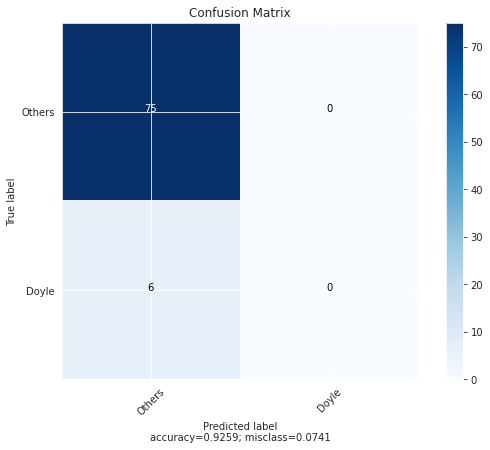

In [58]:
#filename = 'clf_350_50.sav'
#clf_350_50 = pickle.load(open(path+filename, 'rb'))
y_test_350_50_num, y_pred_350_50_num = pert_testing(df_pert_350_num, doyle_w2v_sent_50, clf_350_50, 50)

In [ ]:
#filename = 'clf_1400_50.sav'
#clf_1400_50 = pickle.load(open(path+filename, 'rb'))
y_test_1400_50_num, y_pred_1400_50_num = pert_testing(df_pert_1400_num, doyle_w2v_sent_50, clf_1400_50, 50)

In [ ]:
#filename = 'clf_3500_50.sav'
#clf_3500_50 = pickle.load(open(path+filename, 'rb'))
y_test_3500_50_num, y_pred_3500_50_num = pert_testing(df_pert_3500_num, doyle_w2v_sent_50, clf_3500_50, 50)

## Testing with 300 dim embedding - Synonyms

In [ ]:
#filename = 'clf_350_300.sav'
#clf_350_300 = pickle.load(open(path+filename, 'rb'))
y_test_350_300_syn, y_pred_350_300_syn = pert_testing(df_pert_350_syn, doyle_w2v_sent_300, clf_350_300, 300)

In [ ]:
#filename = 'clf_1400_300.sav'
#clf_1400_300 = pickle.load(open(path+filename, 'rb'))
y_test_1400_300_syn, y_pred_1400_300_syn = pert_testing(df_pert_1400_syn, doyle_w2v_sent_300, clf_1400_300, 300)

In [ ]:
#filename = 'clf_3500_300.sav'
#clf_3500_300 = pickle.load(open(path+filename, 'rb'))
y_test_3500_300_syn, y_pred_3500_300_syn = pert_testing(df_pert_3500_syn, doyle_w2v_sent_300, clf_3500_300, 300)

## Testing with 300 dim embedding - Numericals

In [ ]:
#filename = 'clf_350_300.sav'
#clf_350_300 = pickle.load(open(path+filename, 'rb'))
y_test_350_300_num, y_pred_350_300_num = pert_testing(df_pert_350_num, doyle_w2v_sent_300, clf_350_300, 300)

In [ ]:
#filename = 'clf_1400_300.sav'
#clf_1400_300 = pickle.load(open(path+filename, 'rb'))
y_test_1400_300_num, y_pred_1400_300_num = pert_testing(df_pert_1400_num, doyle_w2v_sent_300, clf_1400_300, 300)

In [ ]:
#filename = 'clf_3500_300.sav'
#clf_3500_300 = pickle.load(open(path+filename, 'rb'))
y_test_3500_300_num, y_pred_3500_300_num = pert_testing(df_pert_3500_num, doyle_w2v_sent_300, clf_3500_300, 300)